In [1]:
from math import floor
from itertools import product
import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt
np.random.seed(101)

In [2]:
def row_col_to_seq(row_col, num_cols):  #Converts state number to row_column format
    return row_col[:,0] * num_cols + row_col[:,1]

def seq_to_col_row(seq, num_cols): #Converts row_column format to state number
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])

In [3]:
MAX_EPISODES = 20000
LEARNING_RATES = [0.1, 0.3, 0.6, 0.9]
NUM_RUNS = 3

def configurations():
    params = [
        [True, False], # wind
        [[0, 4], [3, 6]], # start_state
        [1.0, 0.7], # p
    ]
    
    for config in product(*params):
        yield config

In [4]:
def create_environment(wind=True, start_state=[3, 6], p=0.7):
    num_cols = 10
    num_rows = 10
    obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                             [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                             [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                             [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
    bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
    restart_states = np.array([[3,7],[8,2]])
    start_state = np.array([start_state])
    goal_states = np.array([[0,9],[2,2],[8,7]])

    # create model
    gw = GridWorld(num_rows=num_rows,
                   num_cols=num_cols,
                   start_state=start_state,
                   goal_states=goal_states, wind=wind)
    gw.add_obstructions(obstructed_states=obstructions,
                        bad_states=bad_states,
                        restart_states=restart_states)
    gw.add_rewards(step_reward=-1,
                   goal_reward=10,
                   bad_state_reward=-6,
                   restart_state_reward=-100)
    gw.add_transition_probability(p_good_transition=p,
                                  bias=0.5)
    return gw.create_gridworld()

In [5]:
def plot_Q(Q, message="Q-plot"):
    # 0 -> UP
    # 1-> DOWN
    # 2 -> LEFT
    # 3-> RIGHT
    def x_direct(a):
        if a in [0, 1]:
            return 0
        return 1 if a == 3 else -1
    
    def y_direct(a):
        if a in [3, 2]:
            return 0
        return 1 if a == 0 else -1

    plt.figure(figsize=(7, 7))
    plt.title(message)
    plt.pcolor(Q.max(-1), edgecolors='k', linewidths=2)
    plt.colorbar()
    
    policy = Q.argmax(-1)
    policyx = np.vectorize(x_direct)(policy)
    policyy = np.vectorize(y_direct)(policy)
    idx = np.indices(policy.shape)
    plt.quiver(idx[1].ravel()+0.5, 
               idx[0].ravel()+0.5, 
               policyx.ravel(), 
               policyy.ravel(), 
               pivot="middle", 
               color="red")
    plt.show()

In [6]:
class GridWorld:
    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.gamma = 1 # default is no discounting
        self.wind = wind

    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward = None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward


    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq = row_col_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, self.num_cols)

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal
        
        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states,self.num_states,self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):


                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):
                        
                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1
        return self

    def _get_direction(self, action, direction):

        left = [2,3,1,0]
        right = [3,2,0,1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1,1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state

    def reset(self):
        return int(self.start_state_seq)
      
    def step(self, state, action):
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):
            
            p += self.P[state, next_state, action]
            
            if r <= p:
                break

        if(self.wind and np.random.random() < 0.4):
            arr = self.P[next_state, :, 3]
            next_next = np.where(arr == np.amax(arr))
            next_next = next_next[0][0]
            return next_next, self.R[next_next]
        else:
            return next_state, self.R[next_state]

In [7]:
class RLearner:
    def __init__(self, 
                 env, 
                 algo="qlearning", 
                 strategy="epsilon-greedy", 
                 eps0=0.2, 
                 beta0=100, 
                 lr=0.1,
                 discount=0.9, 
                 max_steps=100):
        
        self.lr = lr
        self.env = env
        self.algo = algo
        self.eps = eps0
        self.beta = beta0
        self.discount = discount
        self.strategy = strategy
        self.max_steps = max_steps
        self.Q = np.zeros((env.num_rows * env.num_cols, env.num_actions))


    def _decay(self, decay_rate=0.99):
        if self.strategy == "epsilon-greedy":
            self.eps = max(0.001, self.eps*decay_rate)
        else:
            self.beta = max(0.001, self.beta*decay_rate)
        

    def _choose_action(self, state):
        n_actions = self.Q.shape[-1]
        if self.strategy == "softmax":
            return np.random.choice(n_actions, p=softmax(self.Q[state]/self.beta))
        return np.random.choice(n_actions) if (np.random.uniform(0, 1) <= self.eps) else self.Q[state].argmax()
    
    
    def _sarsa(self):
        total_reward, steps, done = 0, 0, False
        state = self.env.reset()
        action = self._choose_action(state)
        self.state_visit_count[state] += 1
        while not done:
            next_state, reward = self.env.step(state, action)
            next_action = self._choose_action(next_state)
            # update equation for sarsa
            self.Q[state, action] += self.lr * (reward[0] + (self.discount*self.Q[next_state, next_action]) - self.Q[state, action])
            total_reward += reward[0]
            steps += 1
            state, action = next_state, next_action
            self.state_visit_count[state] += 1
            done = steps > self.max_steps or state in self.env.goal_states_seq
        return total_reward, steps


    def _qlearning(self):
        total_reward, steps, done = 0, 0, False
        state = self.env.reset()
        self.state_visit_count[state] += 1
        while not done: 
            action = self._choose_action(state)
            next_state, reward = self.env.step(state, action)
            # update equation for q-learning
            self.Q[state, action] += (self.lr * (reward[0] + (self.discount*self.Q[next_state].max()) - self.Q[state, action]))
            total_reward += reward[0]
            steps += 1
            state = next_state
            self.state_visit_count[state] += 1
            done = steps > self.max_steps or state in self.env.goal_states_seq
        return total_reward, steps


    def run(self, episodes=10000):
        algorithm = self._qlearning if self.algo == "qlearning" else self._sarsa
        self.state_visit_count = np.zeros(self.env.num_rows * self.env.num_cols)
        episode_rewards, steps_to_completion = [], []
        for i in range(1, episodes+1):
            reward, steps = algorithm()
            episode_rewards.append(reward)
            steps_to_completion.append(steps)
            self._decay(decay_rate=0.99)
        q = self.Q.reshape((self.env.num_rows, self.env.num_cols, self.env.num_actions))
        svc = self.state_visit_count.reshape((self.env.num_rows, self.env.num_cols))
        return q, svc, episode_rewards, steps_to_completion

## SARSA

```softmax```

wind: True; start_state: [0, 4]; p: 1.0; sarsa_softmax; lr: 0.1


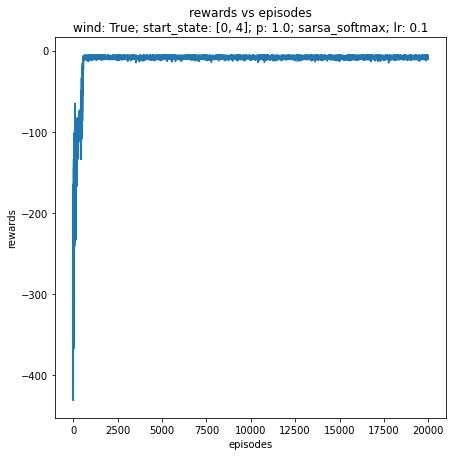

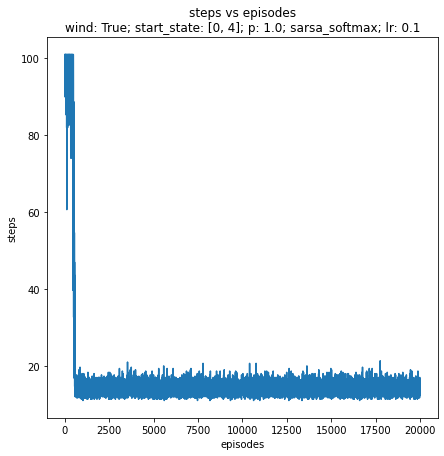

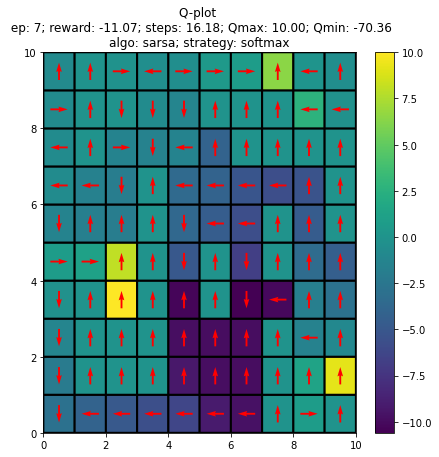

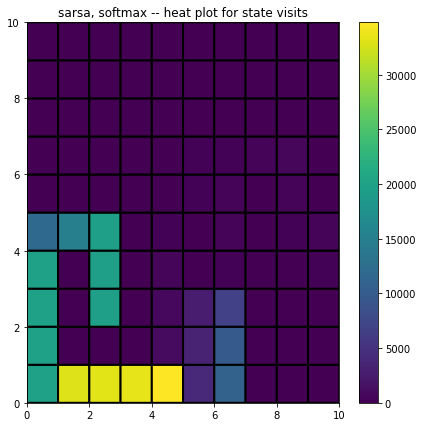

wind: True; start_state: [0, 4]; p: 0.7; sarsa_softmax; lr: 0.1


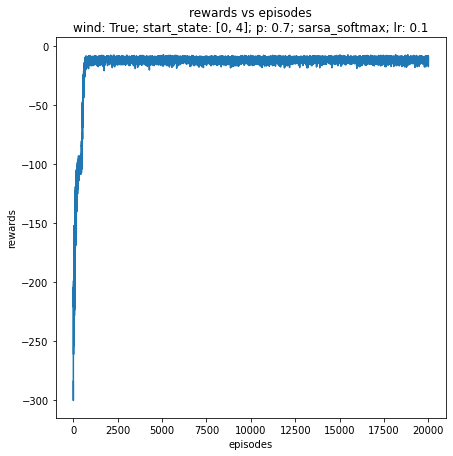

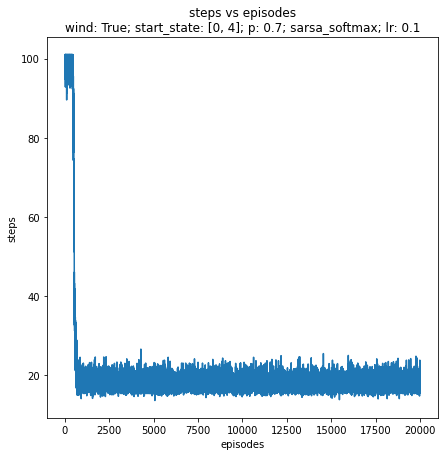

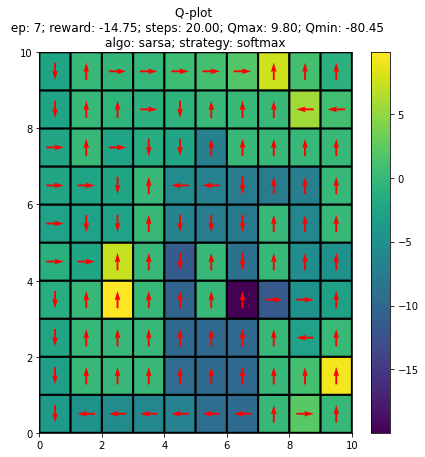

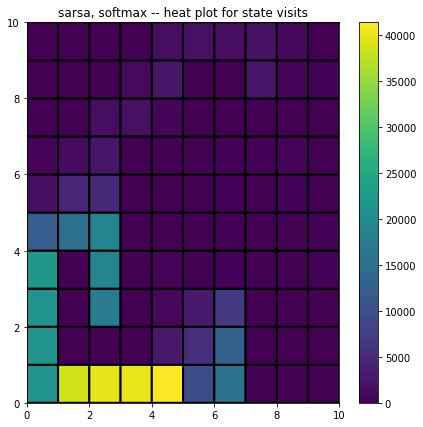

wind: True; start_state: [3, 6]; p: 1.0; sarsa_softmax; lr: 0.9


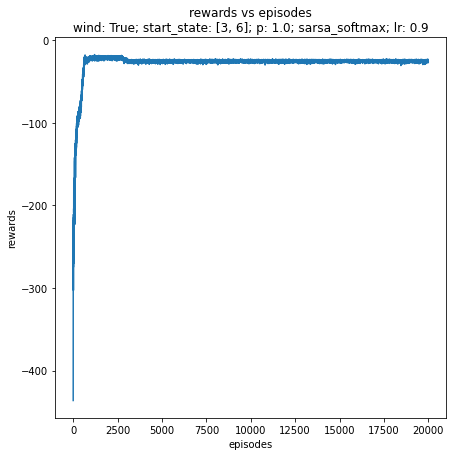

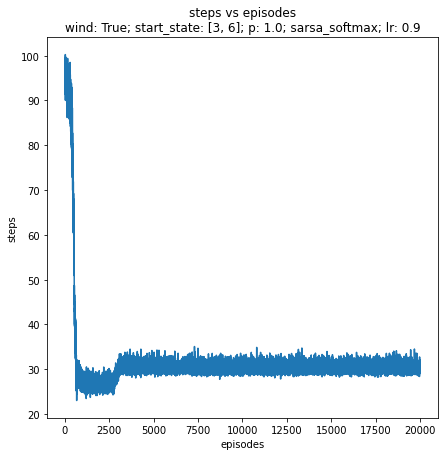

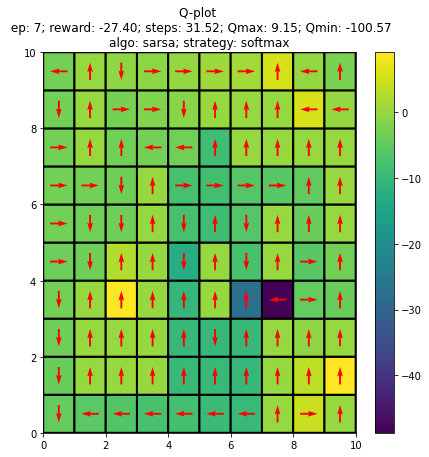

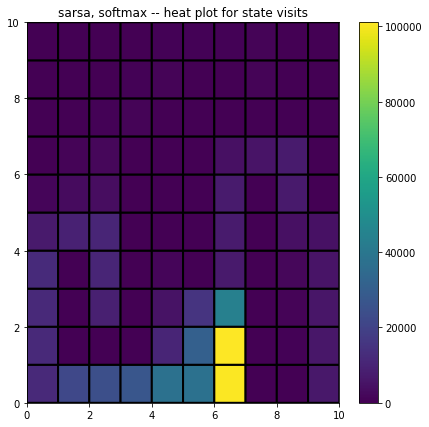

wind: True; start_state: [3, 6]; p: 0.7; sarsa_softmax; lr: 0.1


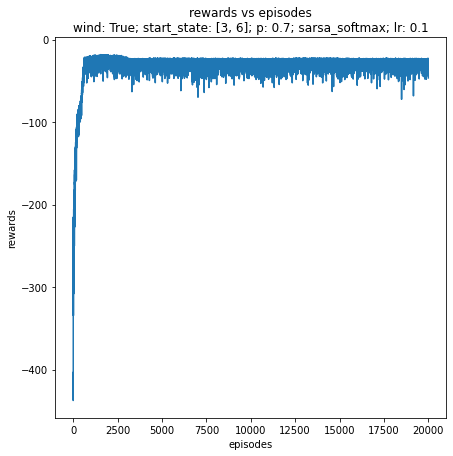

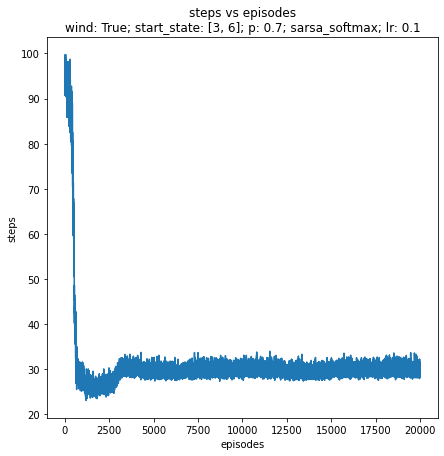

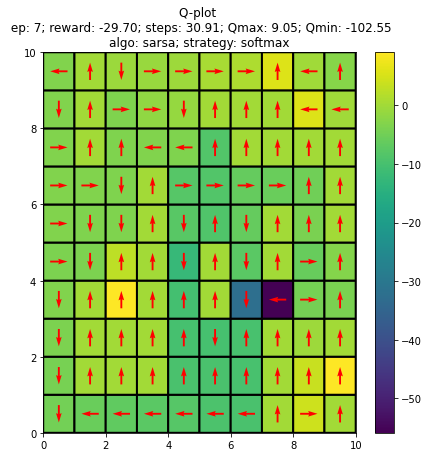

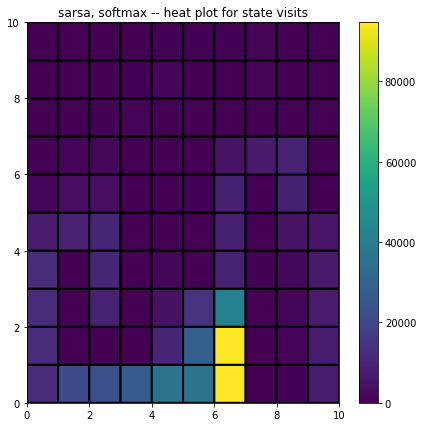

wind: False; start_state: [0, 4]; p: 1.0; sarsa_softmax; lr: 0.9


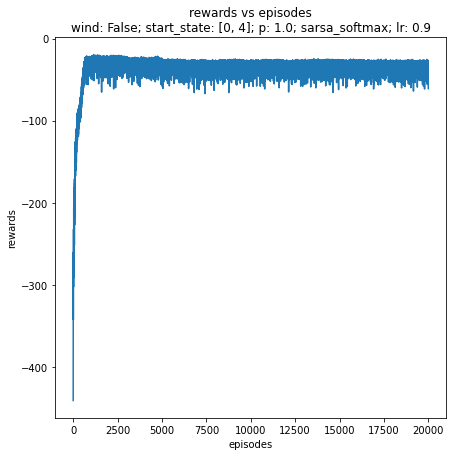

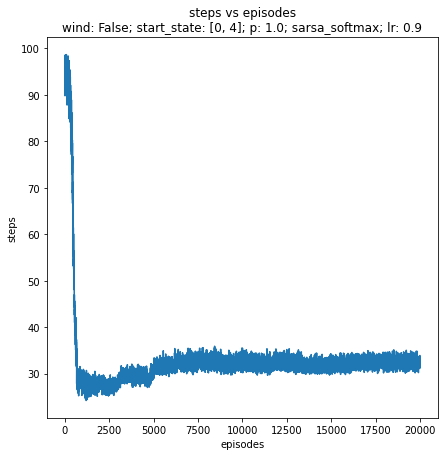

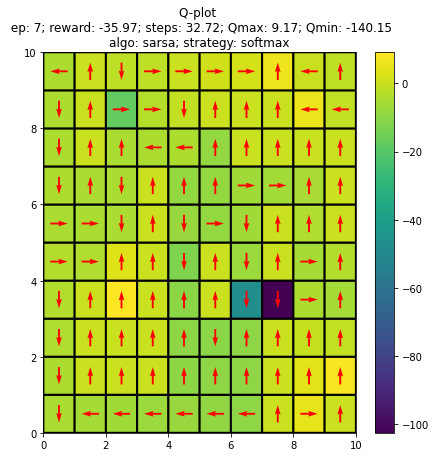

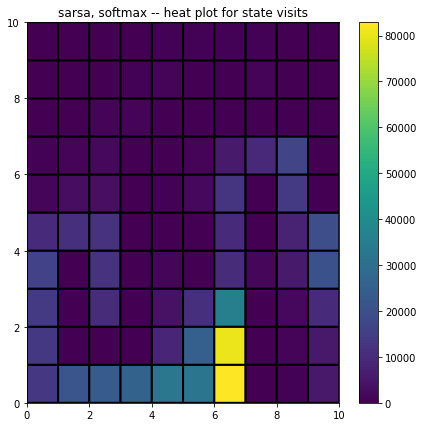

wind: False; start_state: [0, 4]; p: 0.7; sarsa_softmax; lr: 0.3


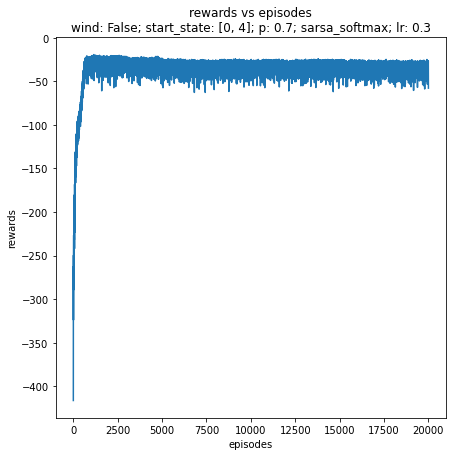

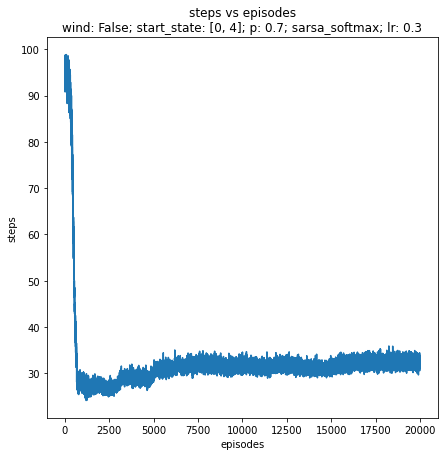

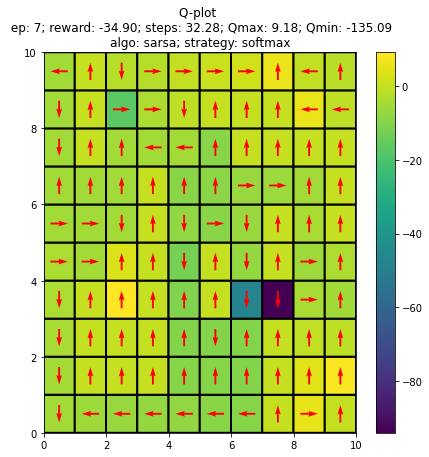

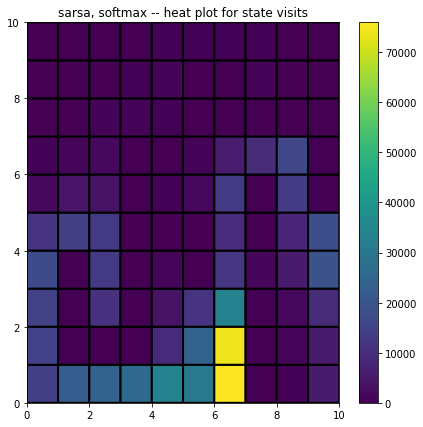

wind: False; start_state: [3, 6]; p: 1.0; sarsa_softmax; lr: 0.9


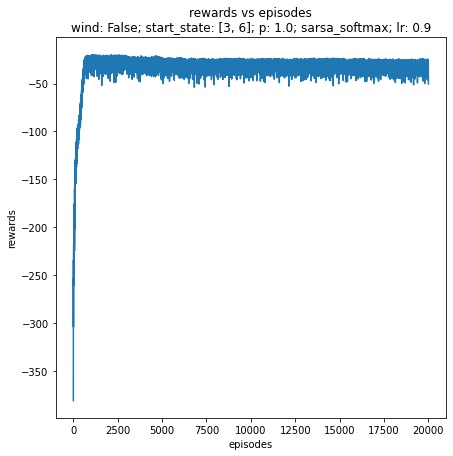

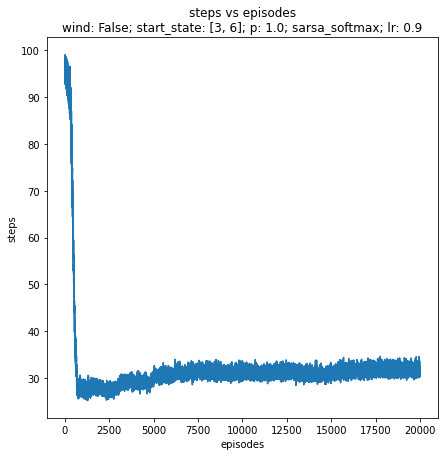

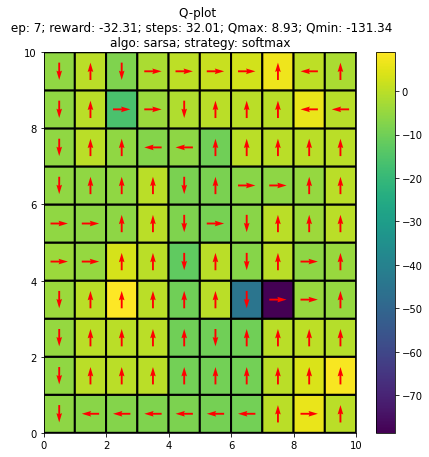

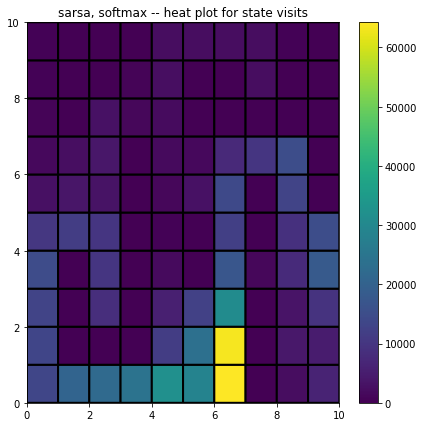

wind: False; start_state: [3, 6]; p: 0.7; sarsa_softmax; lr: 0.6


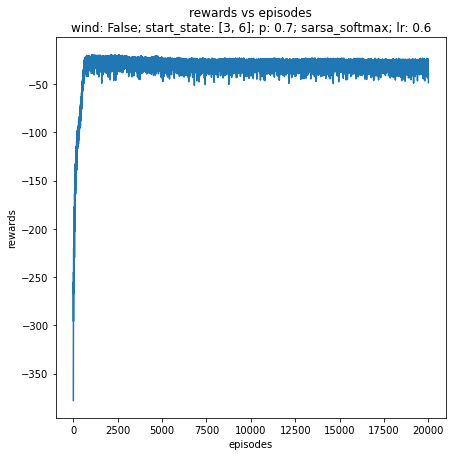

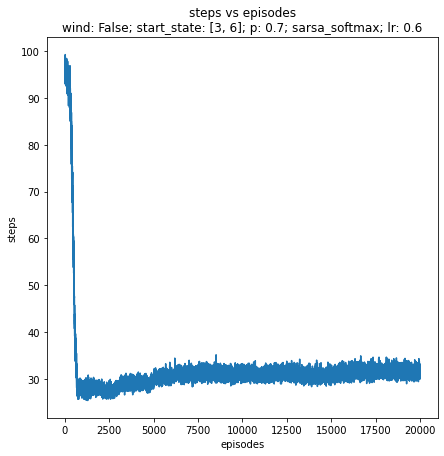

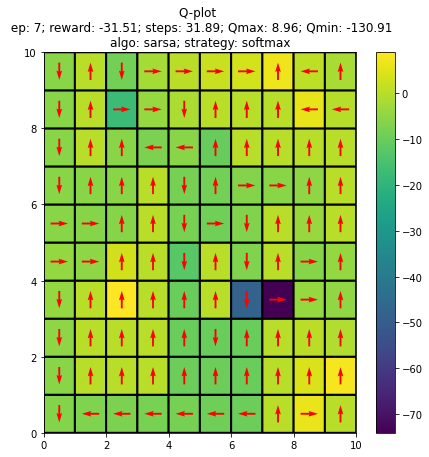

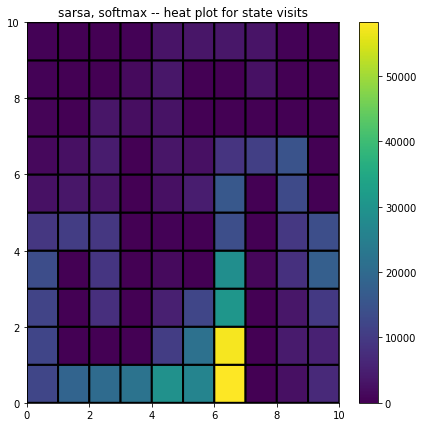

In [8]:
best_set = [(None, -1e9)]*8
q_, rewards_, steps_, state_visits_ = [], [], [], []

for i, (wind, start_state, p) in enumerate(configurations()):
    for lr in LEARNING_RATES:
        
        for _ in range(NUM_RUNS):
            env = create_environment(wind, start_state, p)
            learner = RLearner(env, algo="sarsa", strategy="softmax", lr=lr)
            q, state_visits, rewards, steps = learner.run(episodes=MAX_EPISODES)
            q_.append(q)
            rewards_.append(rewards)
            steps_.append(steps)
            state_visits_.append(state_visits)
        rewards = np.mean(rewards_, axis=0)
        steps = np.mean(steps_, axis=0)
        q = np.mean(q_, axis=0)
        state_visits = np.mean(state_visits_, axis=0)
        
        avg_reward = np.mean(rewards)
        if avg_reward > best_set[i][-1]:
            best_set[i] = ((wind, start_state, p, lr, q, state_visits, rewards, steps), avg_reward)


for ((wind, start_state, p, lr, q, state_visits, rewards, steps), _) in best_set:
    name = (
        f"wind: {wind}; "
        f"start_state: {start_state}; "
        f"p: {p}; "
        f"{learner.algo}_{learner.strategy}; "
        f"lr: {lr}"
    )
    print(name)
    
    # plot rewards
    plt.figure(figsize=(7, 7))
    plt.plot(range(1, MAX_EPISODES+1), rewards)
    plt.title(f"rewards vs episodes\n{name}")
    plt.xlabel("episodes")
    plt.ylabel("rewards")
    plt.show()

    # plot steps 
    plt.figure(figsize=(7, 7))
    plt.plot(range(1, MAX_EPISODES+1), steps)
    plt.title(f"steps vs episodes\n{name}")
    plt.xlabel("episodes")
    plt.ylabel("steps")
    plt.show()
    
    # plot Q-values heatmap
    plot_Q(Q=q, message=(
        f"Q-plot \n ep: {i}; "
        f"reward: {np.mean(rewards):.2f}; "
        f"steps: {np.mean(steps):.2f}; "
        f"Qmax: {q.max():.2f}; "
        f"Qmin: {q.min():.2f}\n"
        f"algo: {learner.algo}; "
        f"strategy: {learner.strategy}"
    ))
    
    # plot state-visits heatmap
    plt.figure(figsize=(7, 7))
    plt.pcolor(state_visits, edgecolor='k', linewidth=2.0)
    plt.title(f"{learner.algo}, {learner.strategy} -- heat plot for state visits")
    plt.colorbar()
    plt.show()

```epsilon-greedy```

wind: True; start_state: [0, 4]; p: 1.0; sarsa_epsilon-greedy; lr: 0.3


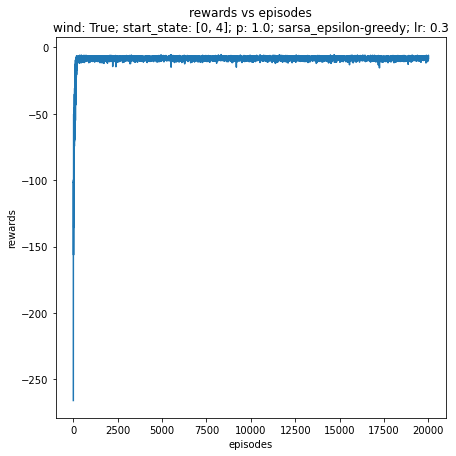

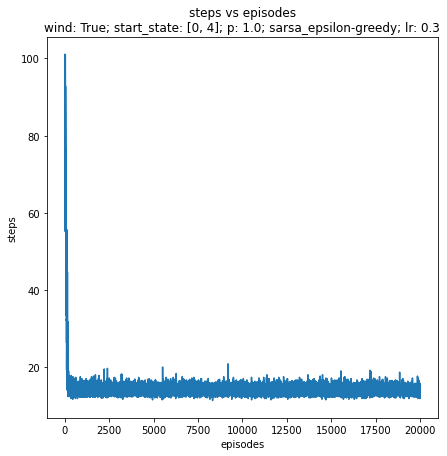

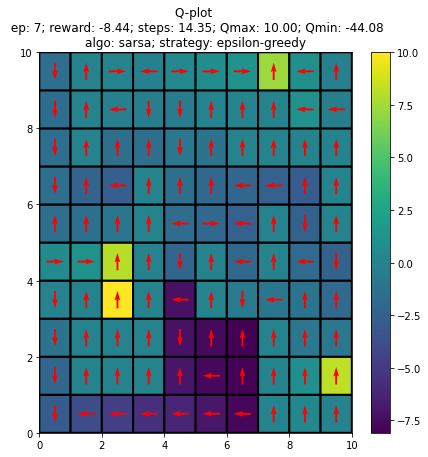

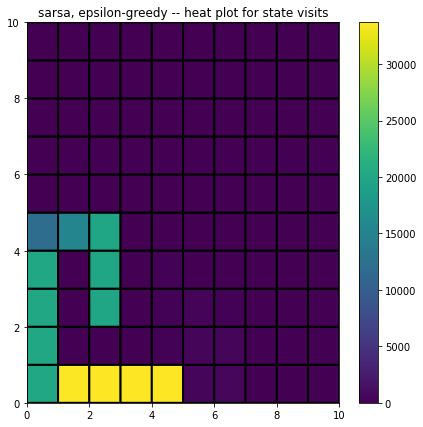

wind: True; start_state: [0, 4]; p: 0.7; sarsa_epsilon-greedy; lr: 0.1


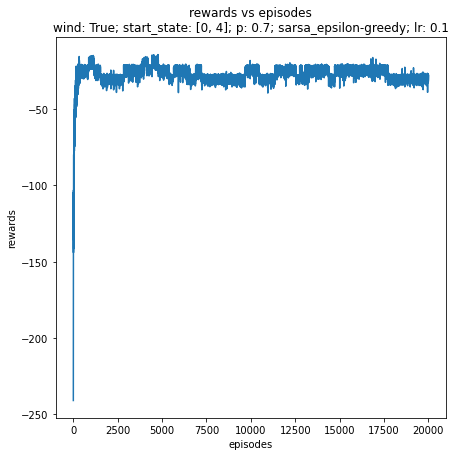

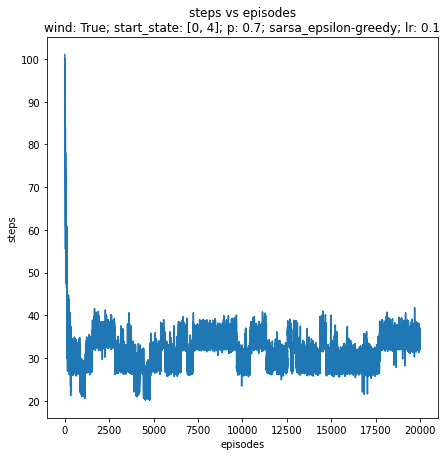

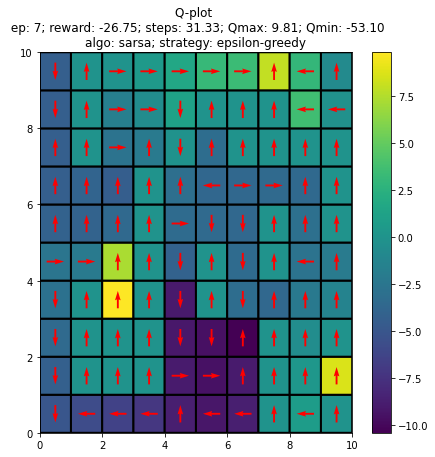

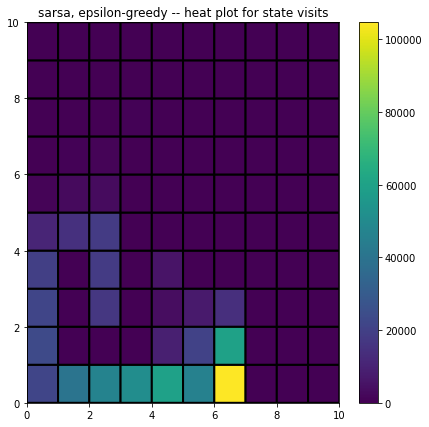

wind: True; start_state: [3, 6]; p: 1.0; sarsa_epsilon-greedy; lr: 0.9


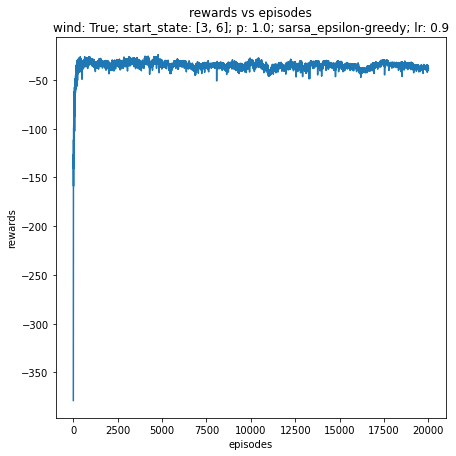

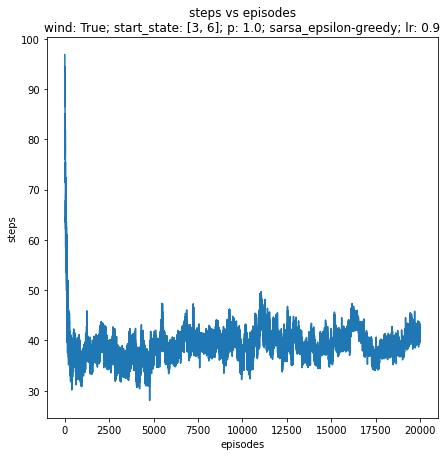

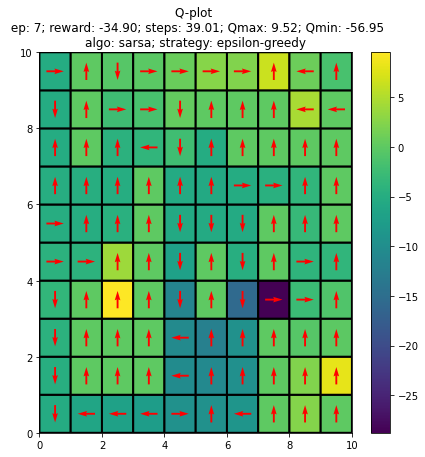

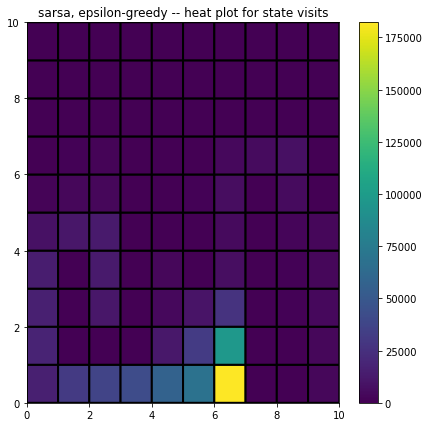

wind: True; start_state: [3, 6]; p: 0.7; sarsa_epsilon-greedy; lr: 0.1


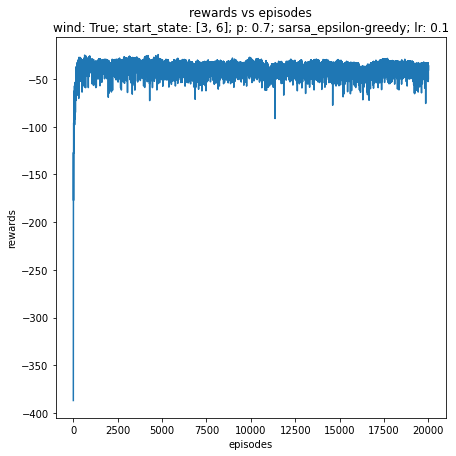

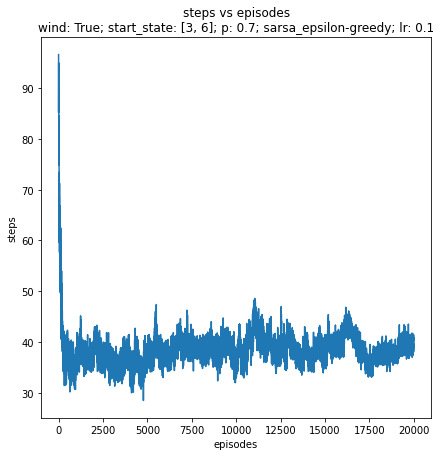

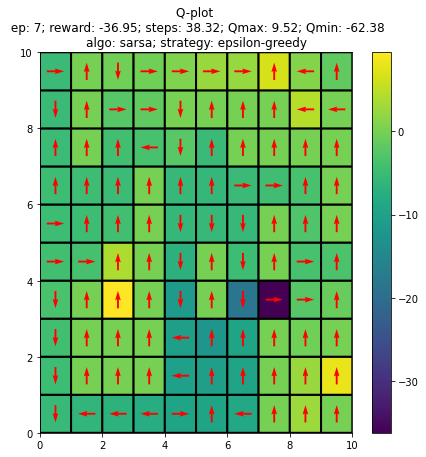

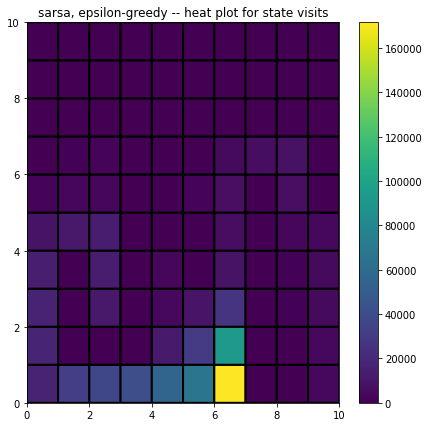

wind: False; start_state: [0, 4]; p: 1.0; sarsa_epsilon-greedy; lr: 0.6


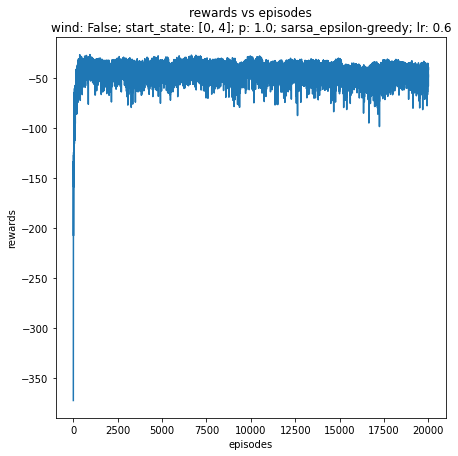

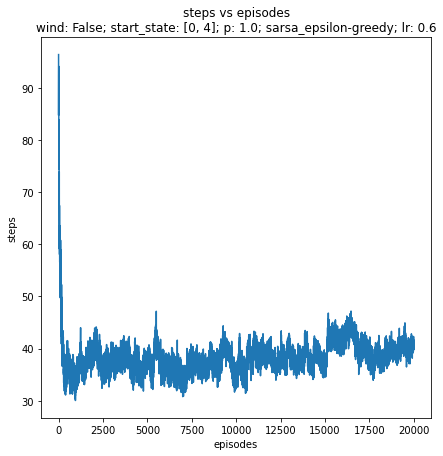

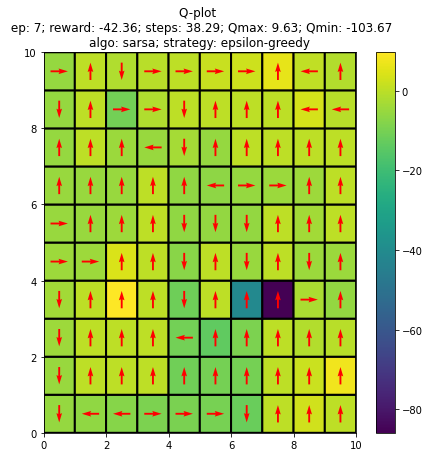

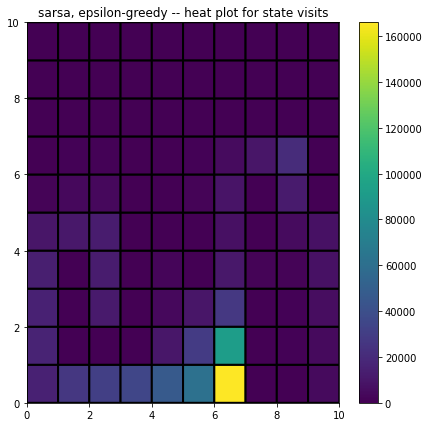

wind: False; start_state: [0, 4]; p: 0.7; sarsa_epsilon-greedy; lr: 0.3


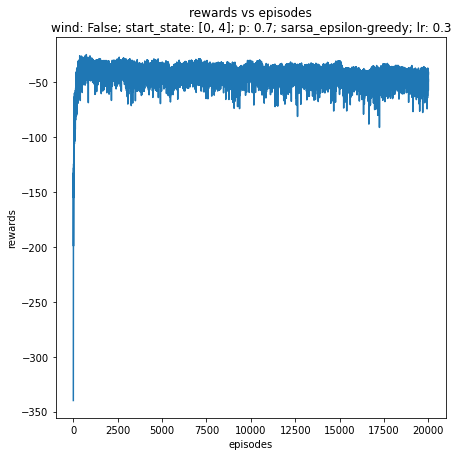

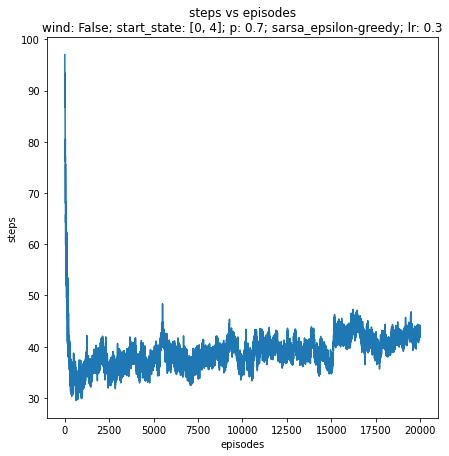

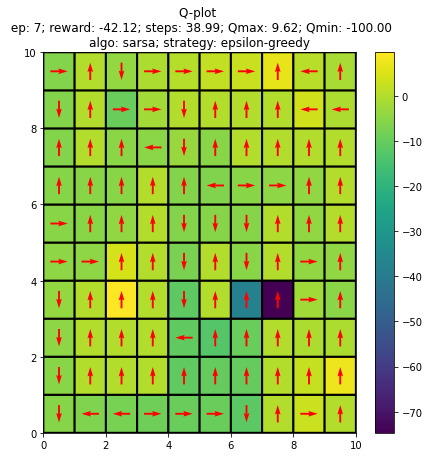

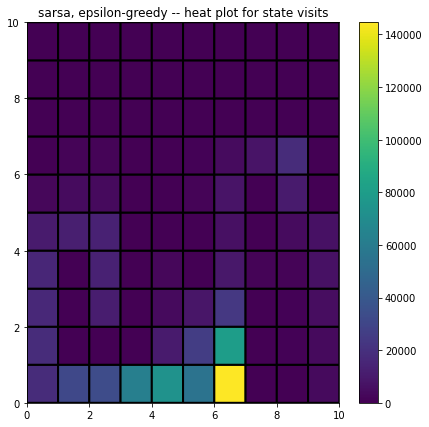

wind: False; start_state: [3, 6]; p: 1.0; sarsa_epsilon-greedy; lr: 0.6


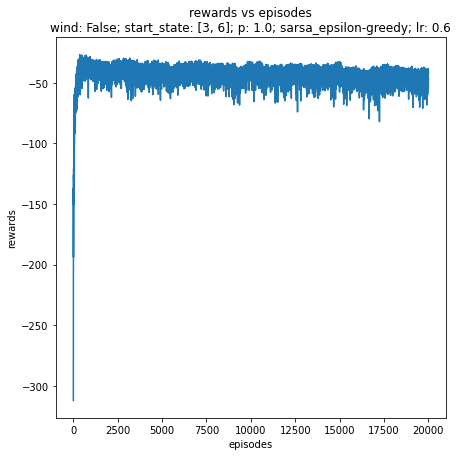

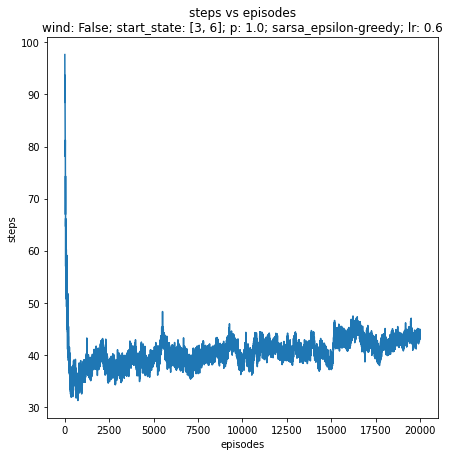

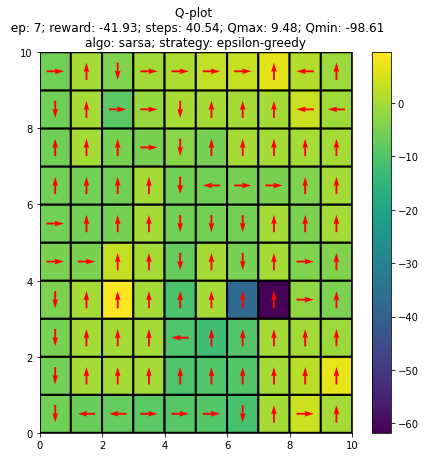

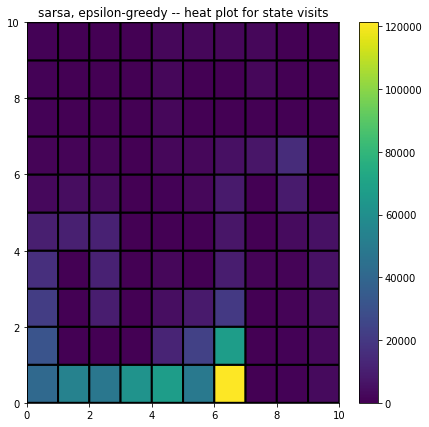

wind: False; start_state: [3, 6]; p: 0.7; sarsa_epsilon-greedy; lr: 0.3


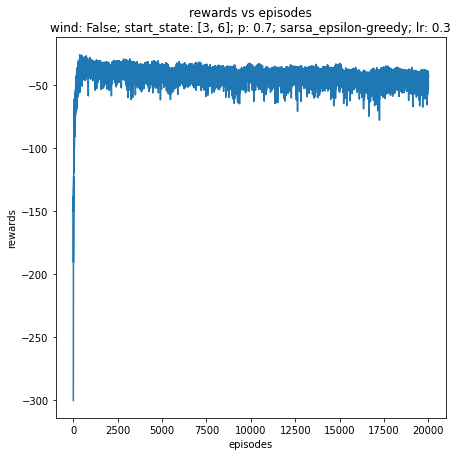

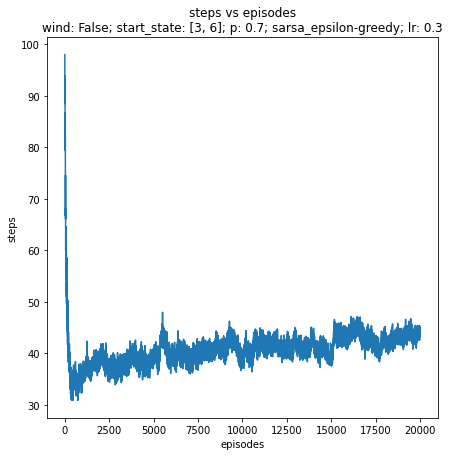

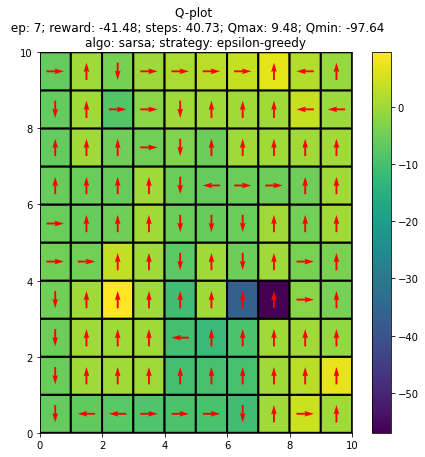

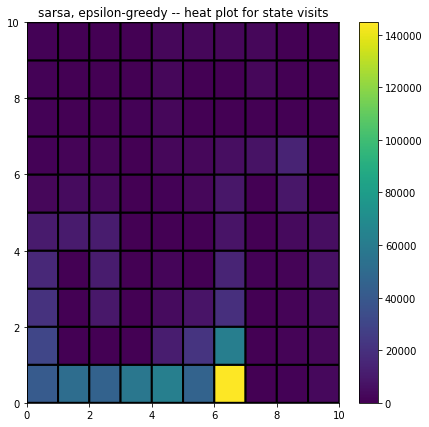

In [9]:
best_set = [(None, -1e9)]*8
q_, rewards_, steps_, state_visits_ = [], [], [], []

for i, (wind, start_state, p) in enumerate(configurations()):
    for lr in LEARNING_RATES:
        
        for _ in range(NUM_RUNS):
            env = create_environment(wind, start_state, p)
            learner = RLearner(env, algo="sarsa", strategy="epsilon-greedy", lr=lr)
            q, state_visits, rewards, steps = learner.run(episodes=MAX_EPISODES)
            q_.append(q)
            rewards_.append(rewards)
            steps_.append(steps)
            state_visits_.append(state_visits)
        rewards = np.mean(rewards_, axis=0)
        steps = np.mean(steps_, axis=0)
        q = np.mean(q_, axis=0)
        state_visits = np.mean(state_visits_, axis=0)
        
        avg_reward = np.mean(rewards)
        if avg_reward > best_set[i][-1]:
            best_set[i] = ((wind, start_state, p, lr, q, state_visits, rewards, steps), avg_reward)


for ((wind, start_state, p, lr, q, state_visits, rewards, steps), _) in best_set:
    name = (
        f"wind: {wind}; "
        f"start_state: {start_state}; "
        f"p: {p}; "
        f"{learner.algo}_{learner.strategy}; "
        f"lr: {lr}"
    )
    print(name)
    
    # plot rewards
    plt.figure(figsize=(7, 7))
    plt.plot(range(1, MAX_EPISODES+1), rewards)
    plt.title(f"rewards vs episodes\n{name}")
    plt.xlabel("episodes")
    plt.ylabel("rewards")
    plt.show()

    # plot steps 
    plt.figure(figsize=(7, 7))
    plt.plot(range(1, MAX_EPISODES+1), steps)
    plt.title(f"steps vs episodes\n{name}")
    plt.xlabel("episodes")
    plt.ylabel("steps")
    plt.show()
    
    # plot Q-values heatmap
    plot_Q(Q=q, message=(
        f"Q-plot \n ep: {i}; "
        f"reward: {np.mean(rewards):.2f}; "
        f"steps: {np.mean(steps):.2f}; "
        f"Qmax: {q.max():.2f}; "
        f"Qmin: {q.min():.2f}\n"
        f"algo: {learner.algo}; "
        f"strategy: {learner.strategy}"
    ))
    
    # plot state-visits heatmap
    plt.figure(figsize=(7, 7))
    plt.pcolor(state_visits, edgecolor='k', linewidth=2.0)
    plt.title(f"{learner.algo}, {learner.strategy} -- heat plot for state visits")
    plt.colorbar()
    plt.show()

# Q-Learning

```softmax```

wind: True; start_state: [0, 4]; p: 1.0; qlearning_softmax; lr: 0.3


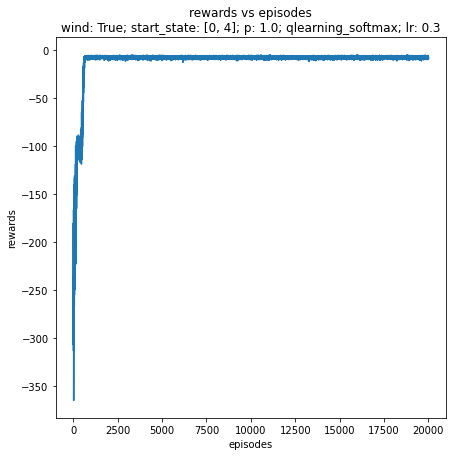

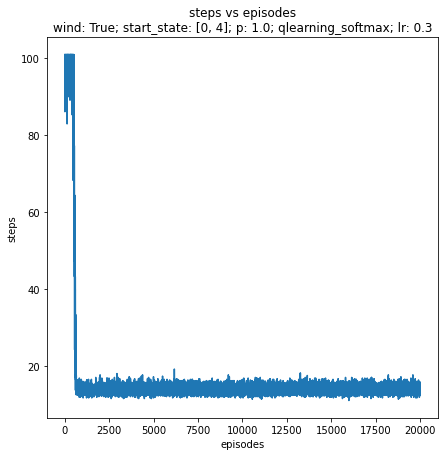

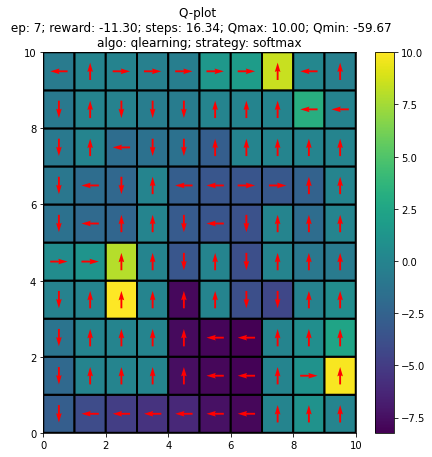

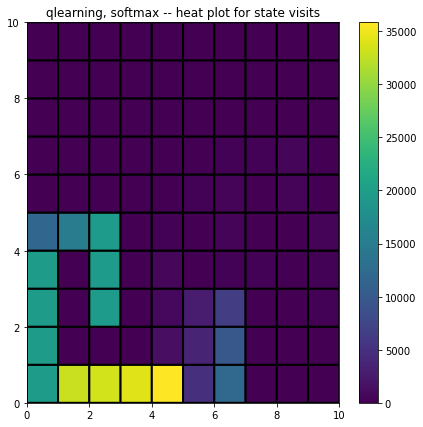

wind: True; start_state: [0, 4]; p: 0.7; qlearning_softmax; lr: 0.1


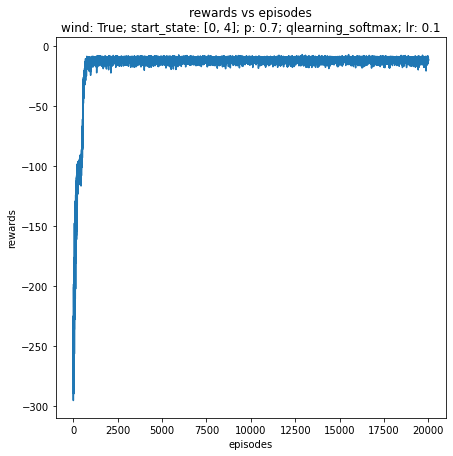

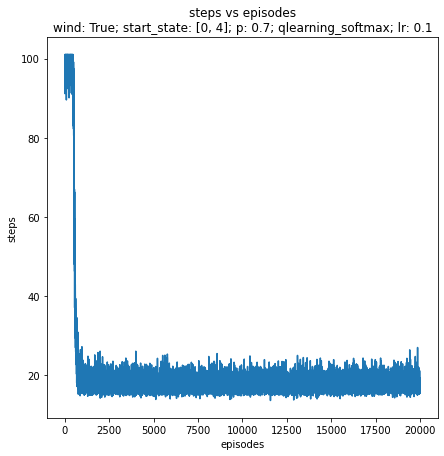

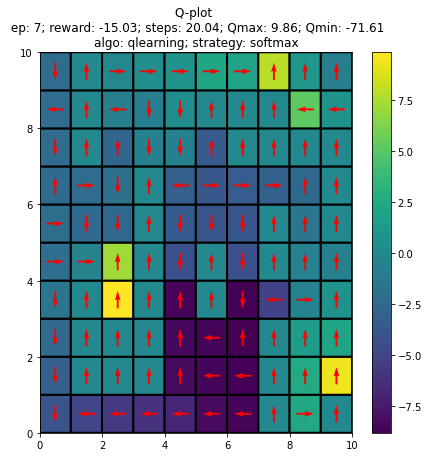

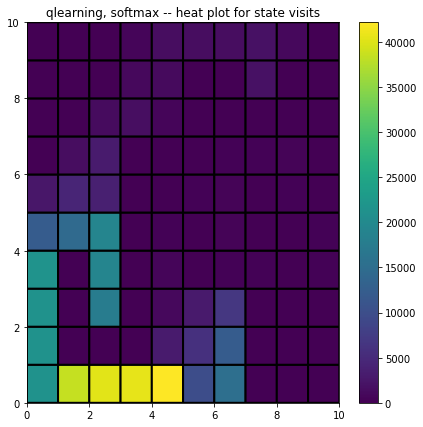

wind: True; start_state: [3, 6]; p: 1.0; qlearning_softmax; lr: 0.9


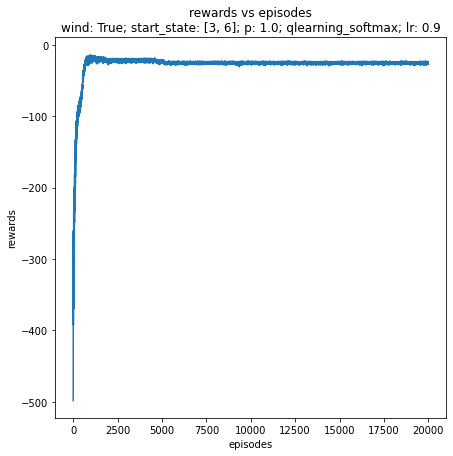

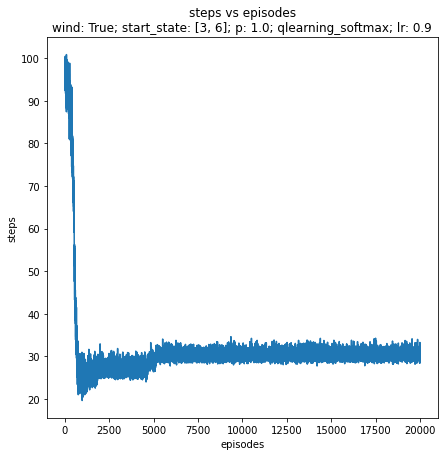

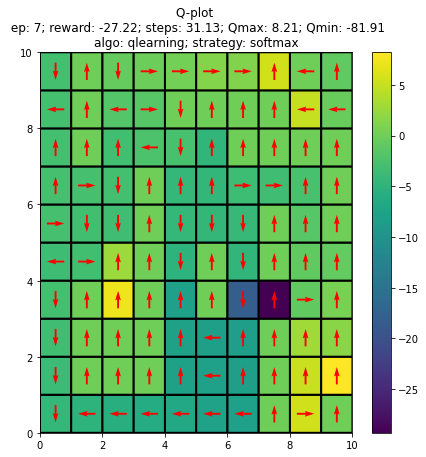

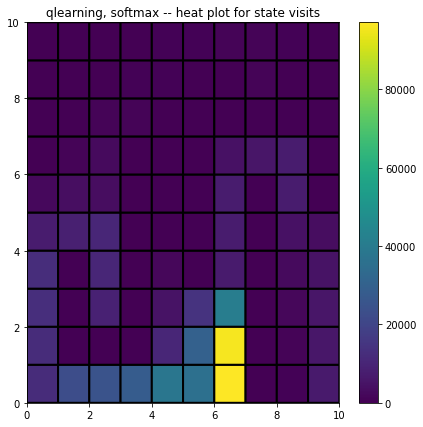

wind: True; start_state: [3, 6]; p: 0.7; qlearning_softmax; lr: 0.1


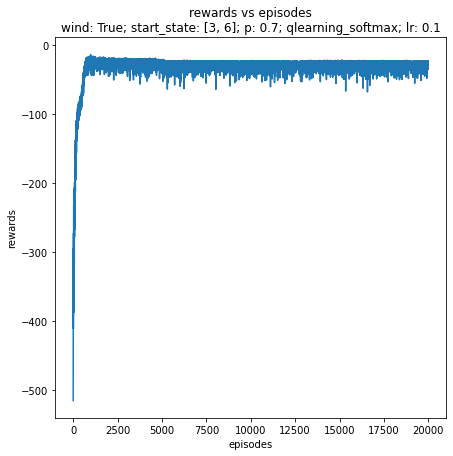

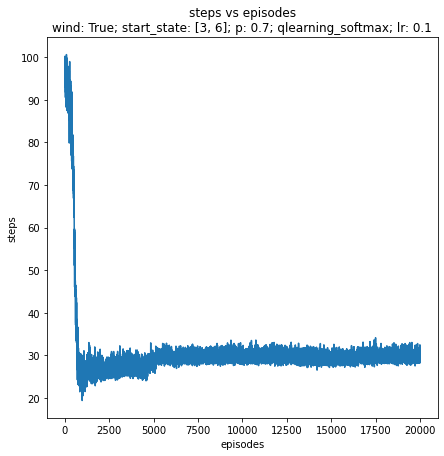

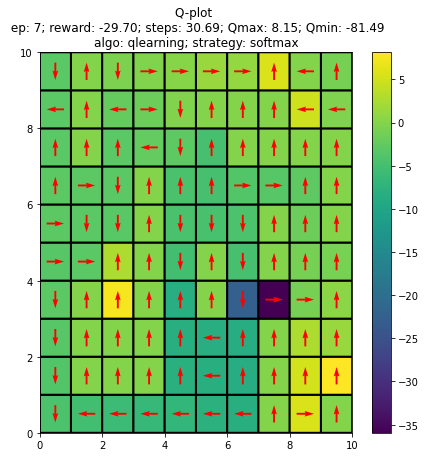

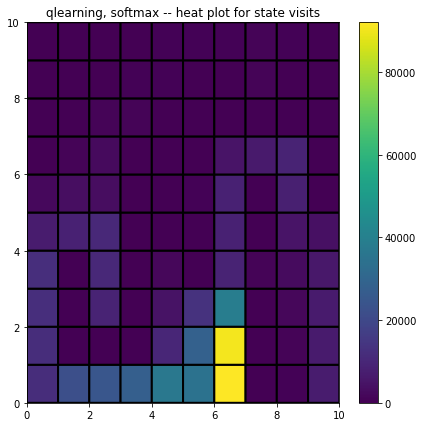

wind: False; start_state: [0, 4]; p: 1.0; qlearning_softmax; lr: 0.9


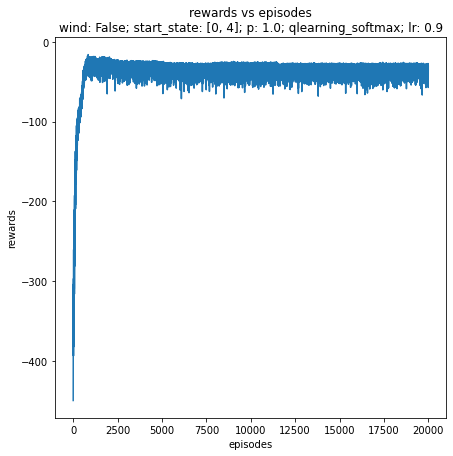

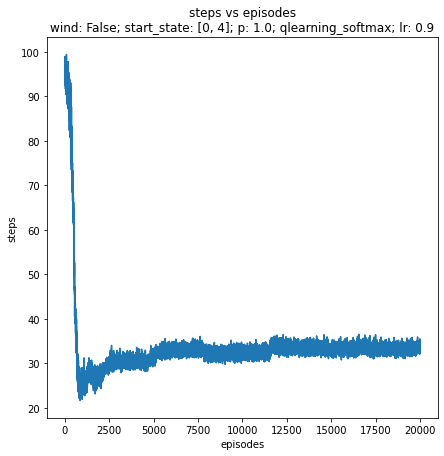

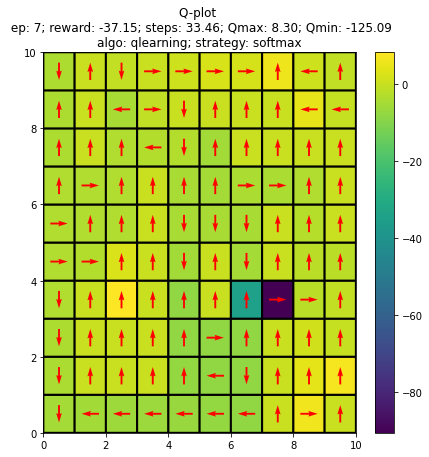

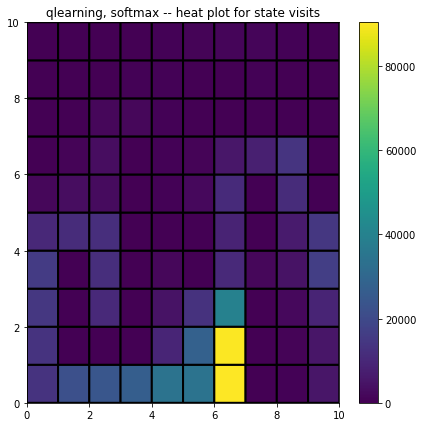

wind: False; start_state: [0, 4]; p: 0.7; qlearning_softmax; lr: 0.3


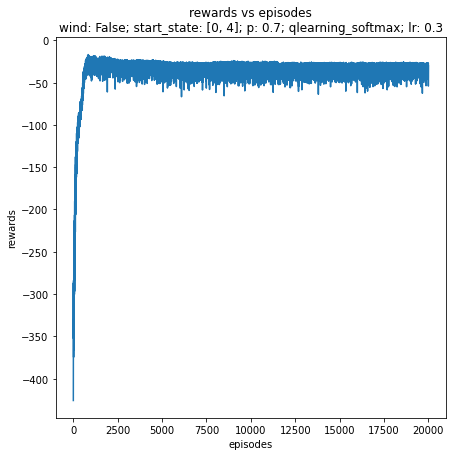

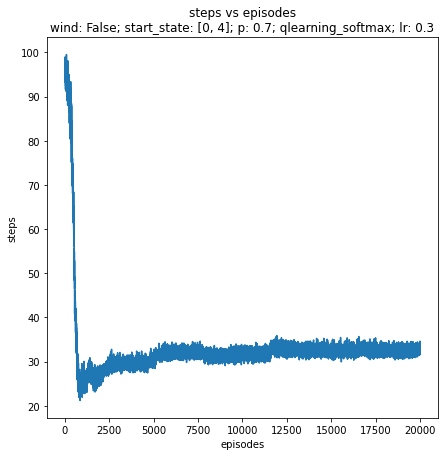

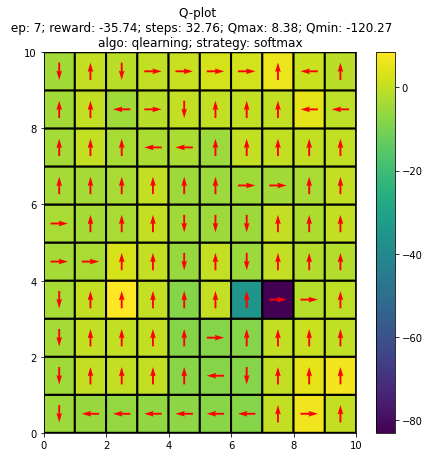

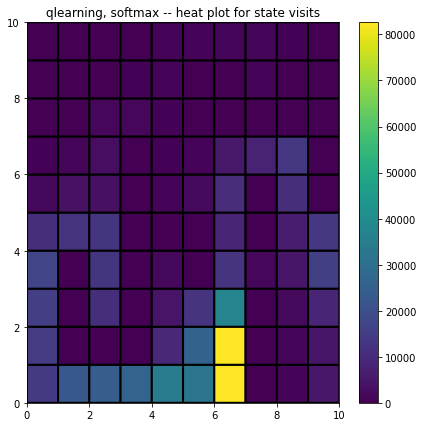

wind: False; start_state: [3, 6]; p: 1.0; qlearning_softmax; lr: 0.9


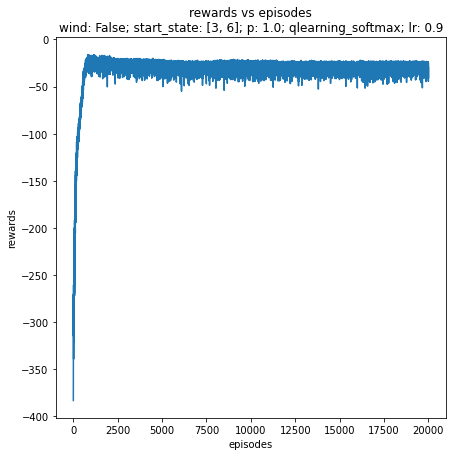

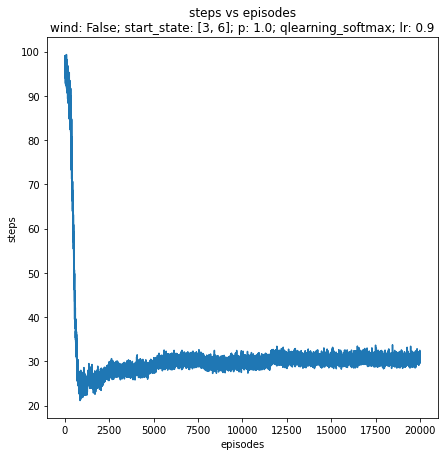

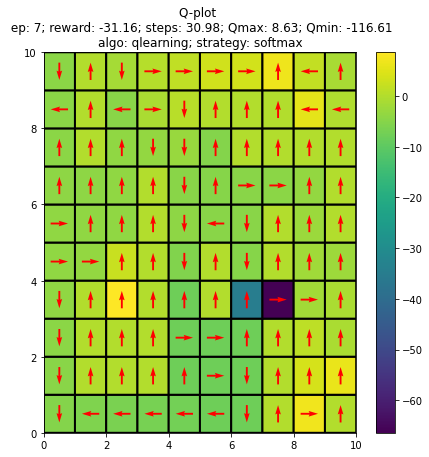

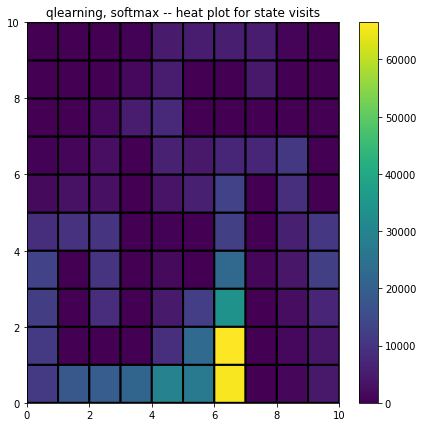

wind: False; start_state: [3, 6]; p: 0.7; qlearning_softmax; lr: 0.9


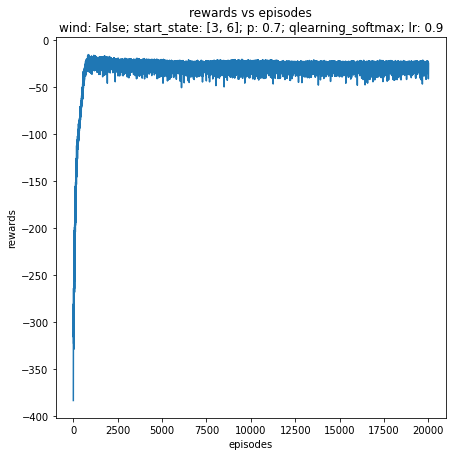

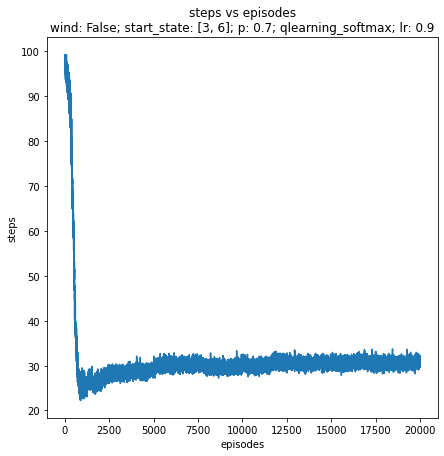

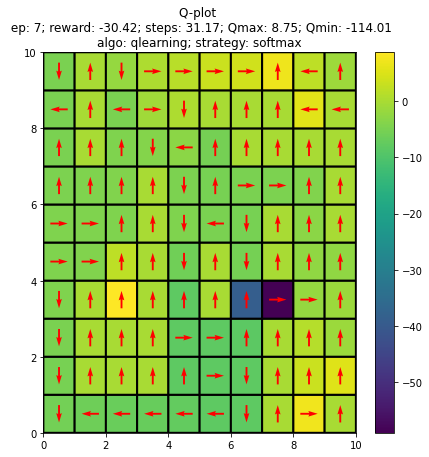

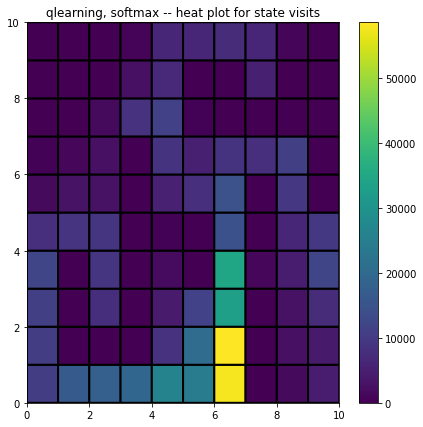

In [10]:
best_set = [(None, -1e9)]*8
q_, rewards_, steps_, state_visits_ = [], [], [], []

for i, (wind, start_state, p) in enumerate(configurations()):
    for lr in LEARNING_RATES:
        
        for _ in range(NUM_RUNS):
            env = create_environment(wind, start_state, p)
            learner = RLearner(env, algo="qlearning", strategy="softmax", lr=lr)
            q, state_visits, rewards, steps = learner.run(episodes=MAX_EPISODES)
            q_.append(q)
            rewards_.append(rewards)
            steps_.append(steps)
            state_visits_.append(state_visits)
        rewards = np.mean(rewards_, axis=0)
        steps = np.mean(steps_, axis=0)
        q = np.mean(q_, axis=0)
        state_visits = np.mean(state_visits_, axis=0)
        
        avg_reward = np.mean(rewards)
        if avg_reward > best_set[i][-1]:
            best_set[i] = ((wind, start_state, p, lr, q, state_visits, rewards, steps), avg_reward)

for ((wind, start_state, p, lr, q, state_visits, rewards, steps), _) in best_set:
    name = (
        f"wind: {wind}; "
        f"start_state: {start_state}; "
        f"p: {p}; "
        f"{learner.algo}_{learner.strategy}; "
        f"lr: {lr}"
    )
    print(name)
    
    # plot rewards
    plt.figure(figsize=(7, 7))
    plt.plot(range(1, MAX_EPISODES+1), rewards)
    plt.title(f"rewards vs episodes\n{name}")
    plt.xlabel("episodes")
    plt.ylabel("rewards")
    plt.show()

    # plot steps 
    plt.figure(figsize=(7, 7))
    plt.plot(range(1, MAX_EPISODES+1), steps)
    plt.title(f"steps vs episodes\n{name}")
    plt.xlabel("episodes")
    plt.ylabel("steps")
    plt.show()
    
    # plot Q-values heatmap
    plot_Q(Q=q, message=(
        f"Q-plot \n ep: {i}; "
        f"reward: {np.mean(rewards):.2f}; "
        f"steps: {np.mean(steps):.2f}; "
        f"Qmax: {q.max():.2f}; "
        f"Qmin: {q.min():.2f}\n"
        f"algo: {learner.algo}; "
        f"strategy: {learner.strategy}"
    ))
    
    # plot state-visits heatmap
    plt.figure(figsize=(7, 7))
    plt.pcolor(state_visits, edgecolor='k', linewidth=2.0)
    plt.title(f"{learner.algo}, {learner.strategy} -- heat plot for state visits")
    plt.colorbar()
    plt.show()

```epsilon-greedy```

wind: True; start_state: [0, 4]; p: 1.0; qlearning_epsilon-greedy; lr: 0.9


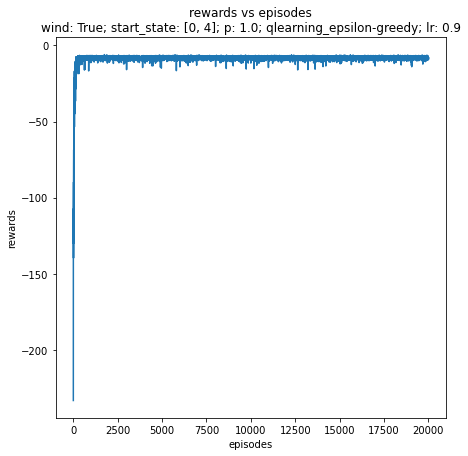

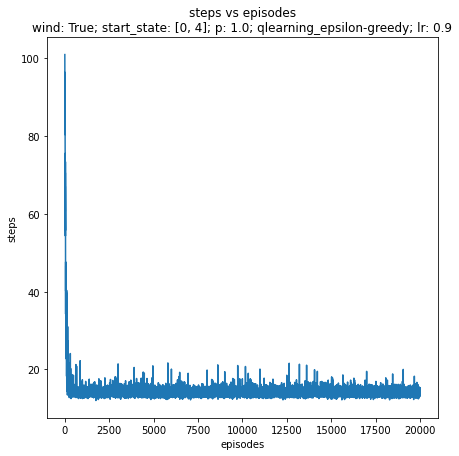

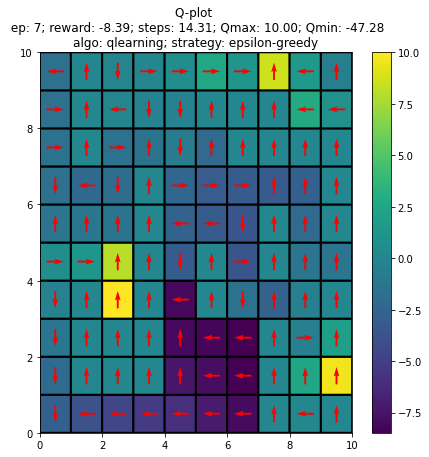

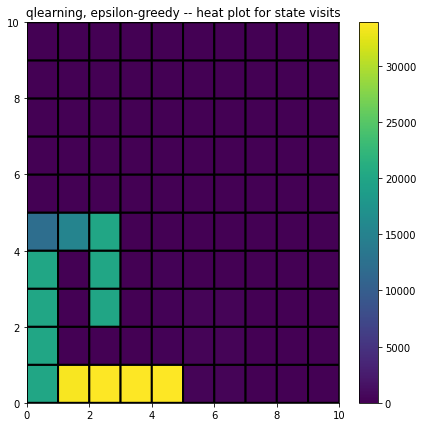

wind: True; start_state: [0, 4]; p: 0.7; qlearning_epsilon-greedy; lr: 0.1


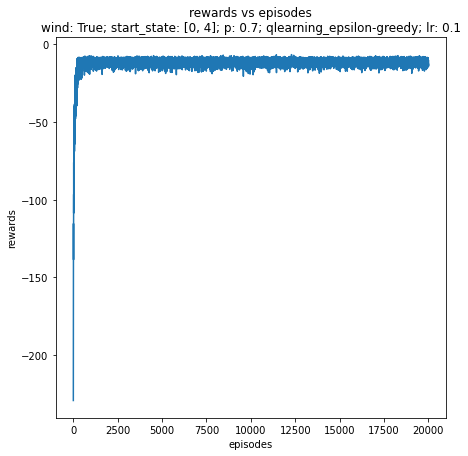

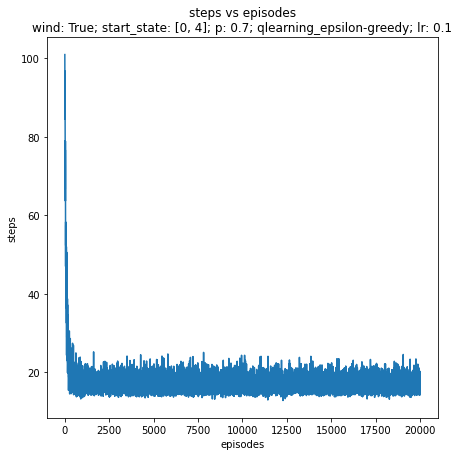

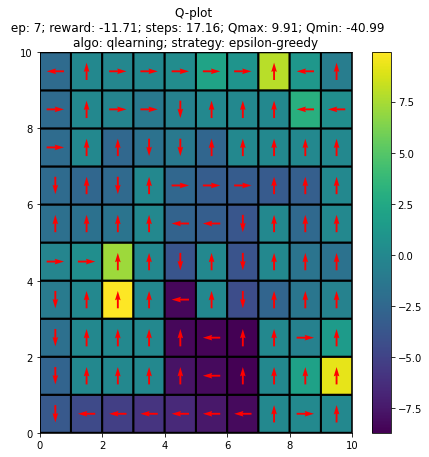

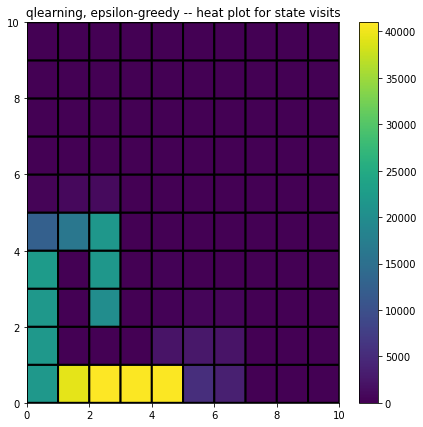

wind: True; start_state: [3, 6]; p: 1.0; qlearning_epsilon-greedy; lr: 0.9


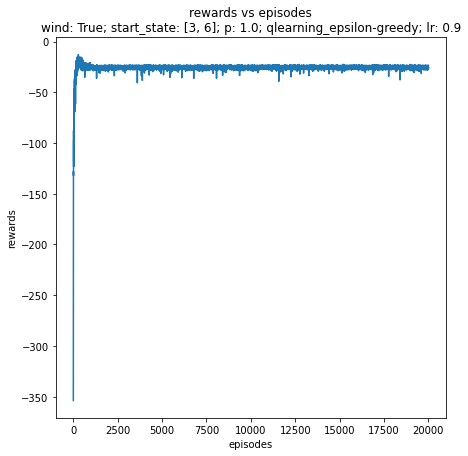

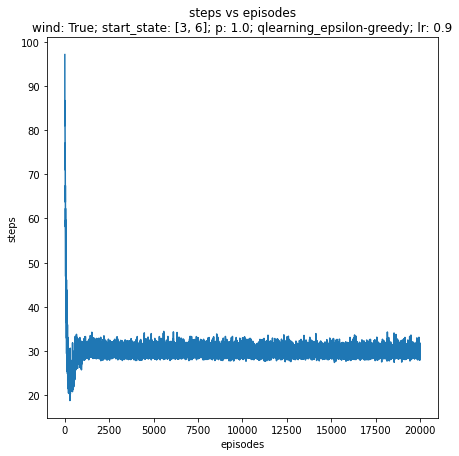

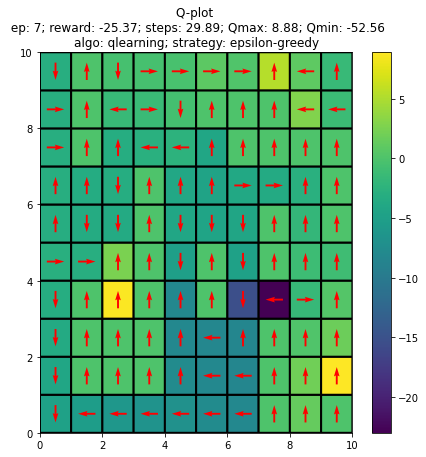

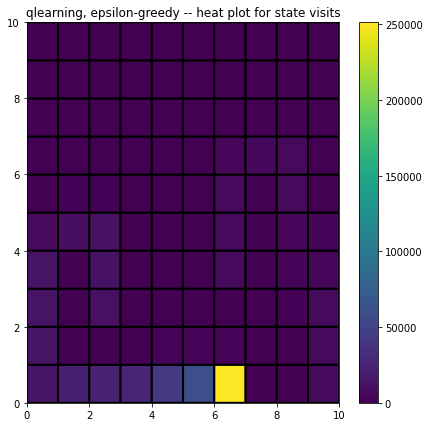

wind: True; start_state: [3, 6]; p: 0.7; qlearning_epsilon-greedy; lr: 0.1


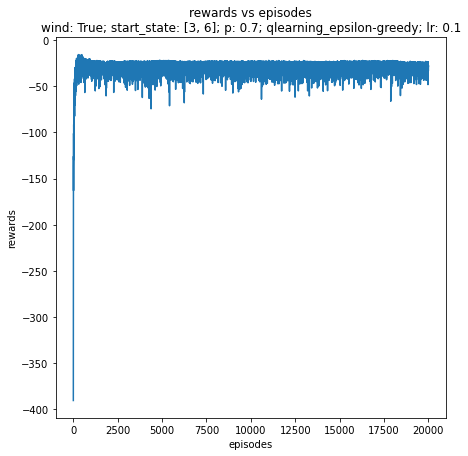

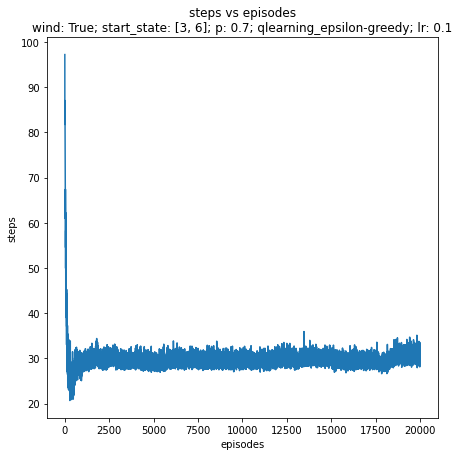

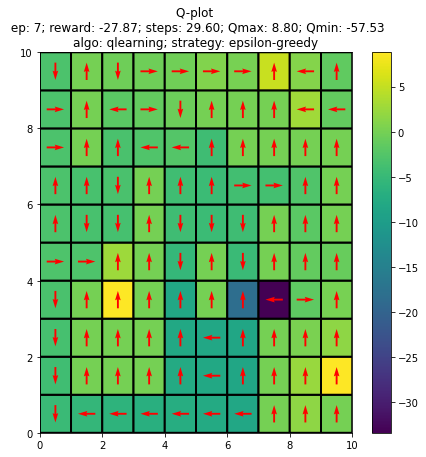

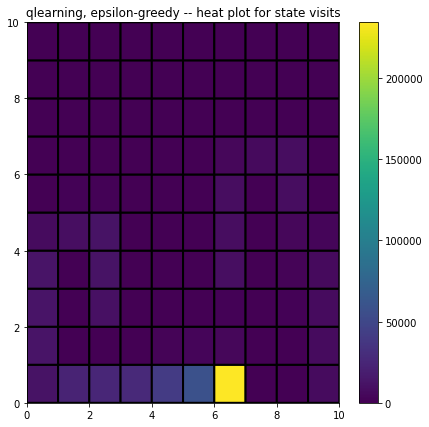

wind: False; start_state: [0, 4]; p: 1.0; qlearning_epsilon-greedy; lr: 0.9


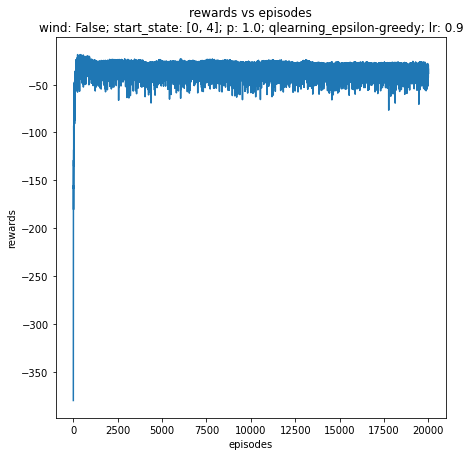

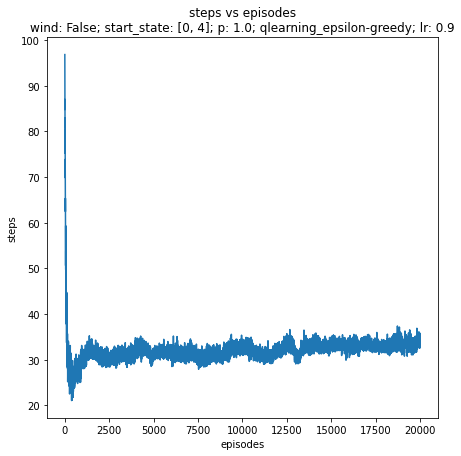

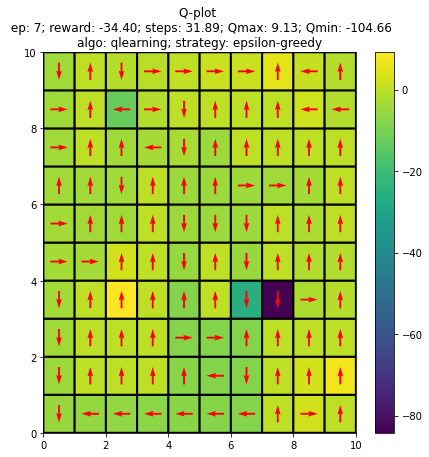

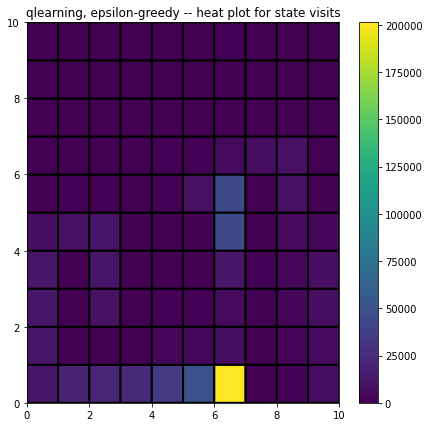

wind: False; start_state: [0, 4]; p: 0.7; qlearning_epsilon-greedy; lr: 0.6


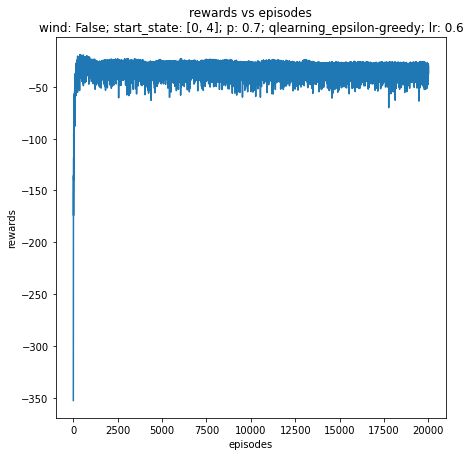

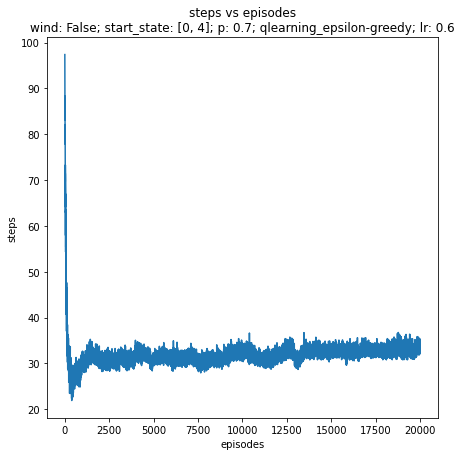

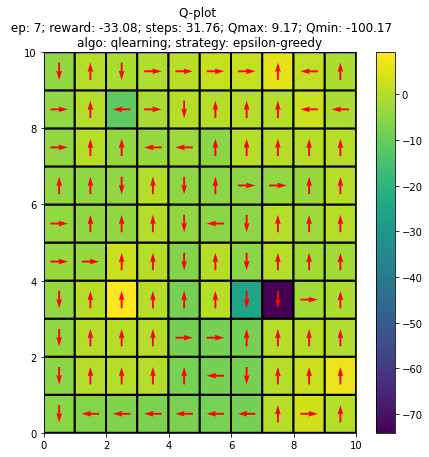

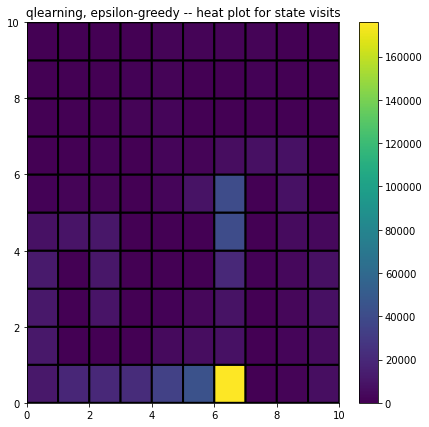

wind: False; start_state: [3, 6]; p: 1.0; qlearning_epsilon-greedy; lr: 0.9


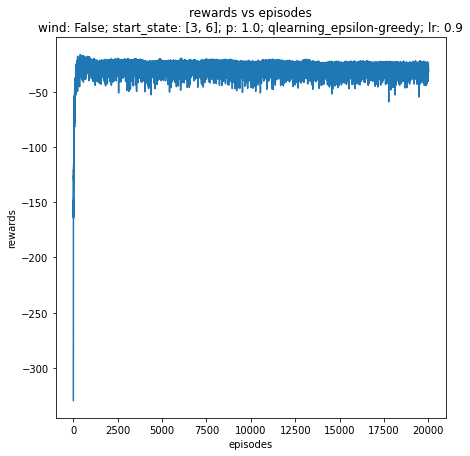

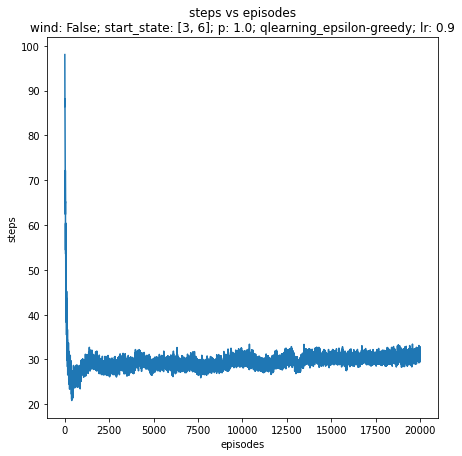

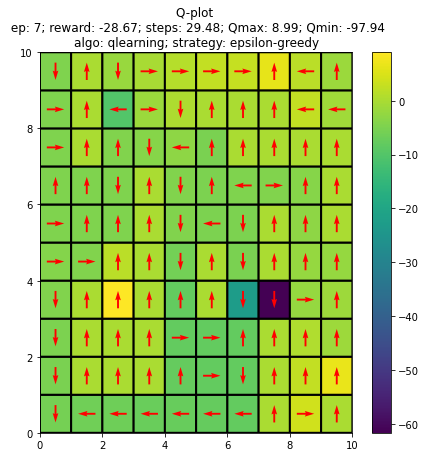

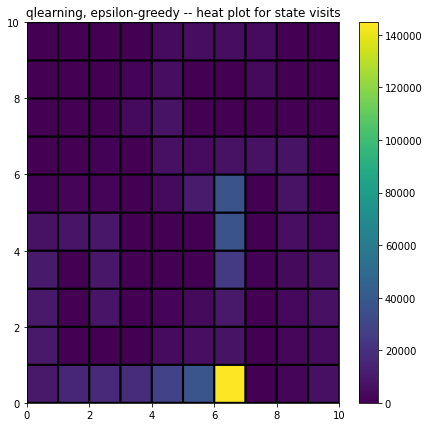

wind: False; start_state: [3, 6]; p: 0.7; qlearning_epsilon-greedy; lr: 0.9


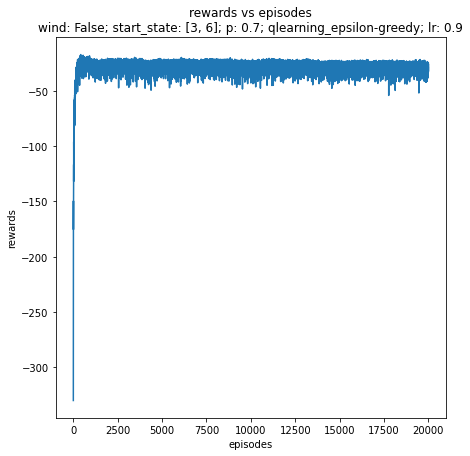

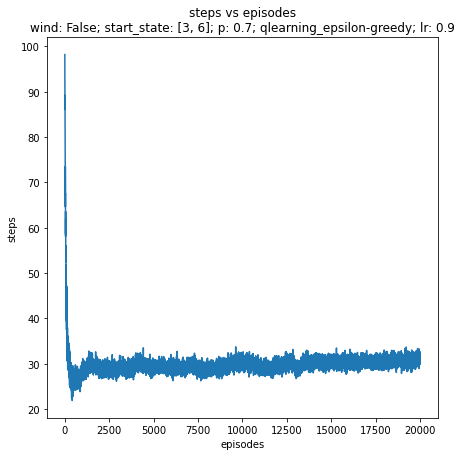

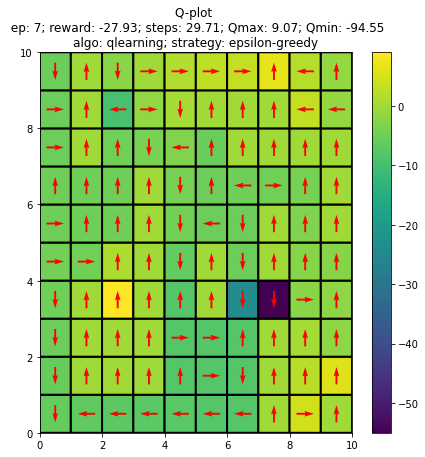

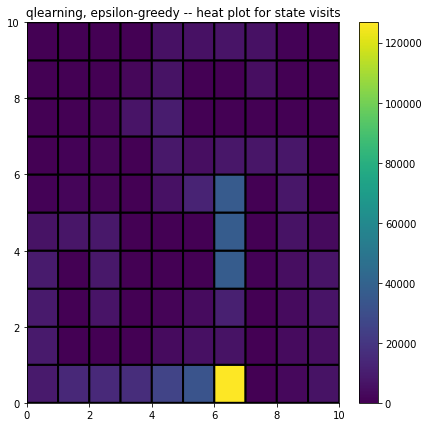

In [11]:
best_set = [(None, -1e9)]*8
q_, rewards_, steps_, state_visits_ = [], [], [], []

for i, (wind, start_state, p) in enumerate(configurations()):
    for lr in LEARNING_RATES:
        
        for _ in range(NUM_RUNS):
            env = create_environment(wind, start_state, p)
            learner = RLearner(env, algo="qlearning", strategy="epsilon-greedy", lr=lr)
            q, state_visits, rewards, steps = learner.run(episodes=MAX_EPISODES)
            q_.append(q)
            rewards_.append(rewards)
            steps_.append(steps)
            state_visits_.append(state_visits)
        rewards = np.mean(rewards_, axis=0)
        steps = np.mean(steps_, axis=0)
        q = np.mean(q_, axis=0)
        state_visits = np.mean(state_visits_, axis=0)
        
        avg_reward = np.mean(rewards)
        if avg_reward > best_set[i][-1]:
            best_set[i] = ((wind, start_state, p, lr, q, state_visits, rewards, steps), avg_reward)


for ((wind, start_state, p, lr, q, state_visits, rewards, steps), _) in best_set:
    name = (
        f"wind: {wind}; "
        f"start_state: {start_state}; "
        f"p: {p}; "
        f"{learner.algo}_{learner.strategy}; "
        f"lr: {lr}"
    )
    print(name)
    
    # plot rewards
    plt.figure(figsize=(7, 7))
    plt.plot(range(1, MAX_EPISODES+1), rewards)
    plt.title(f"rewards vs episodes\n{name}")
    plt.xlabel("episodes")
    plt.ylabel("rewards")
    plt.show()

    # plot steps 
    plt.figure(figsize=(7, 7))
    plt.plot(range(1, MAX_EPISODES+1), steps)
    plt.title(f"steps vs episodes\n{name}")
    plt.xlabel("episodes")
    plt.ylabel("steps")
    plt.show()
    
    # plot Q-values heatmap
    plot_Q(Q=q, message=(
        f"Q-plot \n ep: {i}; "
        f"reward: {np.mean(rewards):.2f}; "
        f"steps: {np.mean(steps):.2f}; "
        f"Qmax: {q.max():.2f}; "
        f"Qmin: {q.min():.2f}\n"
        f"algo: {learner.algo}; "
        f"strategy: {learner.strategy}"
    ))
    
    # plot state-visits heatmap
    plt.figure(figsize=(7, 7))
    plt.pcolor(state_visits, edgecolor='k', linewidth=2.0)
    plt.title(f"{learner.algo}, {learner.strategy} -- heat plot for state visits")
    plt.colorbar()
    plt.show()